<a href="https://colab.research.google.com/github/Ragnarok540/sympy-tutorial/blob/main/elastic_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# https://www.youtube.com/watch?v=K6FzJUDPE9M

import sympy as smp
import sympy.physics.mechanics as smp_mech
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
from matplotlib.transforms import Affine2D

In [9]:
smp_mech.init_vprinting()

m, g, k, ell_0, t = smp.symbols('m g k ell_0 t')

theta, ell = smp_mech.dynamicsymbols('theta ell')

theta_dot = smp.diff(theta, t)
theta_ddot = smp.diff(theta_dot, t)
ell_dot = smp.diff(ell, t)
ell_ddot = smp.diff(ell_dot, t)

T = smp.Rational(1, 2) * m * (ell_dot**2 + (ell_0 + ell)**2 * theta_dot**2)
V = smp.Rational(1, 2) * k * ell**2 - m * g * (ell_0 + ell) * smp.cos(theta)
L = T - V

eqn_1 = smp.diff(smp.diff(L, theta_dot), t) - smp.diff(L, theta)
eqn_2 = smp.diff(smp.diff(L, ell_dot), t) - smp.diff(L, ell)
sln = smp.solve([eqn_1, eqn_2], [theta_ddot, ell_ddot])

f = smp.Matrix([theta_dot, sln[theta_ddot], ell_dot, sln[ell_ddot]])
f = smp.simplify(f)
x = smp.Matrix([theta, theta_dot, ell, ell_dot])
x_dot = smp.diff(x, t)

smp.Eq(x_dot, f)

        ⎡                 θ̇                 ⎤
        ⎢                                   ⎥
⎡ θ̇ ⎤   ⎢      -(g⋅sin(θ) + 2⋅el̇l⋅θ̇)        ⎥
⎢   ⎥   ⎢      ──────────────────────       ⎥
⎢ θ̈ ⎥   ⎢            ell₀ + ell             ⎥
⎢   ⎥ = ⎢                                   ⎥
⎢el̇l⎥   ⎢                el̇l                ⎥
⎢   ⎥   ⎢                                   ⎥
⎣el̈l⎦   ⎢      2              k⋅ell        2⎥
        ⎢ell₀⋅θ̇  + g⋅cos(θ) - ───── + ell⋅θ̇ ⎥
        ⎣                       m           ⎦

In [20]:
f1 = f[1].subs([(g, 9.81), (ell_0, 1)])
f1_fun = smp.lambdify([theta, theta_dot, ell, ell_dot], f1)
f1

-(9.81⋅sin(θ) + 2⋅el̇l⋅θ̇) 
─────────────────────────
         ell + 1         

In [24]:
f3 = f[3].subs([(g, 9.81), (ell_0, 1), (k, 20), (m, 1)])
f3_fun = smp.lambdify([theta, theta_dot, ell, ell_dot], f3)
f3

     2                           2
ell⋅θ̇  - 20⋅ell + 9.81⋅cos(θ) + θ̇ 

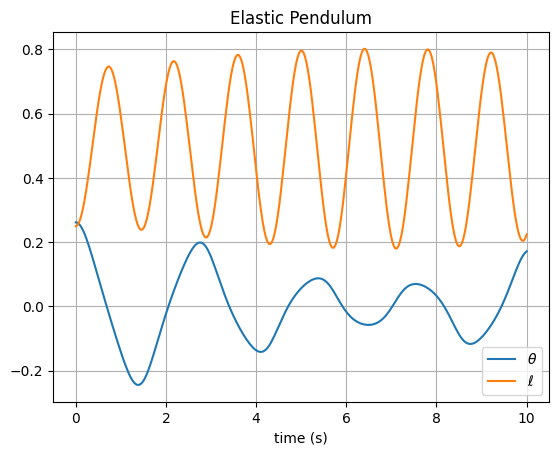

In [26]:
def spring_mass_ODE(t, y):
    theta = y[0]
    theta_dot = y[1]
    ell = y[2]
    ell_dot = y[3]

    return (
        theta_dot,
        f1_fun(theta, theta_dot, ell, ell_dot),
        ell_dot,
        f3_fun(theta, theta_dot, ell, ell_dot),
    )

x0 = np.array([np.deg2rad(15), 0, 0.25, 0])

sol = solve_ivp(spring_mass_ODE, [0, 10], x0, t_eval=np.linspace(0, 10, 10 * 30))

theta = sol.y[0]
ell = sol.y[2]
t = sol.t

plt.plot(t, theta, label="$\\theta$")
plt.plot(t, ell, label="$\\ell$")
plt.legend()
plt.grid()
plt.xlabel("time (s)")
plt.title('Elastic Pendulum')
plt.show()

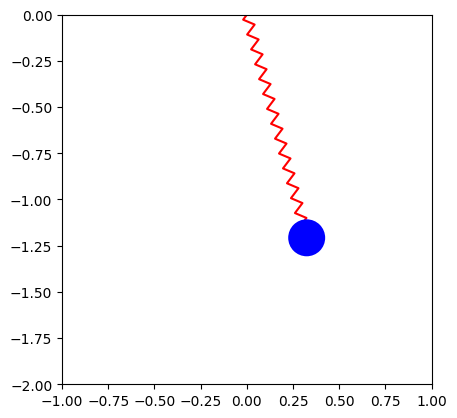

In [27]:
def generate_spring(n):
    data = np.zeros((2, n + 2))
    data[:, -1] = [0, -1]

    for i in range(1,n+1):
        data[0, i] = -1 / (2 * n) if i % 2 else 1 / (2 * n)
        data[1, i] = -(2 * i - 1) / (2 * n)

    return data

fig = plt.figure()
ax = fig.add_subplot(aspect='equal')
ax.set_xlim(-1, 1)
ax.set_ylim(-2, 0)

ell_0 = 1

data = ell_0 * np.append(generate_spring(30), np.ones((1, 30 + 2)), axis=0)
spring = Line2D(data[0, :], data[1, :], color='r')
circle = ax.add_patch(plt.Circle((0, 0), 0.1, fc='b', zorder=3))
ax.add_line(spring)

def animate(i):
    spring_length = (ell_0 + ell[i])
    px = spring_length * np.sin(theta[i])
    py = -spring_length * np.cos(theta[i])
    circle.set_center((px, py))

    A = Affine2D().scale(2 / spring_length, spring_length).rotate(theta[i]).get_matrix()
    data_new = A @ data
    spring.set_data(data_new[0, :], data_new[1, :])

ani = animation.FuncAnimation(fig, animate, frames=len(t))
ffmpeg_writer = animation.FFMpegWriter(fps=30)
ani.save('elastic_pendulum.gif', writer=ffmpeg_writer)